# Finding a Relationship Between Ratings and Sentiment

Now that we have completed a simple Sentiment Analysis on a sample of the text, it will be advantageous to compare these results against the reviews' ratings to see if there is a relationship between the two variables. When querying the review text, we can include their ratings as well and use it in the model.

In [3]:
import pandas as pd
import numpy as np
import psycopg2

#Connect to database; input depends on your settings
conn = psycopg2.connect(database=<db_name>, user=<user_name>, password=<password>, host=<host_name>, port=<port_name>)

print("Opened database successfully")

cur = conn.cursor()

Opened database successfully


In [19]:
'''
This query selects reviews made within a year of the recall, and also tags them with their classification. Moreover,
it randomly selects 200 rather than just the first 200, so that it is not dependent on the order in which the items were added.
'''
cur.execute('SELECT rv.review_text, rv.overall from review rv \
            join recalledproduct rp on rv.product_id = rp.product_id\
            join recall rc on rp.recall_id = rc.recall_id\
            join event e on rc.event_id = e.event_id where \
            @ (date_part(\'month\',TIMESTAMP \'epoch\' + rv.unix_review_time * INTERVAL \'1 second\')\
            - date_part(\'month\', e.initiation_date)) <= 12 order by random() limit 500;')

specified_recall = pd.DataFrame(cur.fetchall())

cur.execute('SELECT rv.review_text, rv.overall from review rv \
            where rv.product_id not in (\
            select distinct product_id from recalledproduct) order by random() limit 500;')

specified_no_recall = pd.DataFrame(cur.fetchall())

print(specified_recall.shape)
print(specified_no_recall.shape)

(500, 2)
(500, 2)


In [20]:
specified_recall

,0,1
0,"The bars are very good, dark chocolate and Fig...",5
1,These are the best pancakes I have ever had. I...,5
2,This is literally the most disgusting thing I ...,1
3,We are so excited about this coconut milk. We ...,5
4,Taste dried out,1
5,After being diagnosed with Celiac disease 2yrs...,5
6,Delicious and comes in a BPA free can! Awesome...,5
7,My spouse grabbed this for the first time last...,5
8,Most of my family of eight managed to eat this...,1
9,This brand is proving to be very excellent and...,5


We can now perform the sentiment analysis as done above, and append the quantified sentiment to the data frames. From there, we will evaluate the correlation between the two variables. We will quantify the sentiment of each text using the SentimentIntensityAnalyzer from the NLTK package which is based on the [VADER](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) approach, which has been optimized for social media texts. VADER takes into account capital letters and stopwords, so since we have not preprocessed the data this measure is sufficient. Although the algorithm is optimized for extremely short texts, Amazon reviews are reasonably short enough to implement this method. NOTE: You must download vader_lexicon by running nltk.download() in the terminal.

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [22]:
sent_int_an = SentimentIntensityAnalyzer()

In [23]:
recall_compound = []
recall_neg = []
recall_neu = []
recall_pos = []
no_recall_compound = []
no_recall_neg = []
no_recall_neu = []
no_recall_pos = []

#get vader polarity scores added to the data frames
for row in range(specified_recall.shape[0]):
    
    polarities_recall = sent_int_an.polarity_scores(specified_recall.iloc[row,0])
    polarities_no_recall = sent_int_an.polarity_scores(specified_no_recall.iloc[row,0])
    
    recall_compound.append(polarities_recall['compound'])
    no_recall_compound.append(polarities_no_recall['compound'])
    recall_neg.append(polarities_recall['neg'])
    no_recall_neg.append(polarities_no_recall['neg'])
    recall_neu.append(polarities_recall['neu'])
    no_recall_neu.append(polarities_no_recall['neu'])
    recall_pos.append(polarities_recall['pos'])
    no_recall_pos.append(polarities_no_recall['pos'])
    

In [24]:
#add to dataframe
specified_recall['compound'] = recall_compound
specified_no_recall['compound'] = no_recall_compound

specified_recall['neg'] = recall_neg
specified_no_recall['neg'] = no_recall_neg

specified_recall['neu'] = recall_neu
specified_no_recall['neu'] = no_recall_neu

specified_recall['pos'] = recall_pos
specified_no_recall['pos'] = no_recall_pos

#also just for ease of comprehension, I will update the other column names as well
specified_recall.columns = ['review','rating','compound','neg','neu','pos']
specified_no_recall.columns = ['review','rating','compound','neg','neu','pos']

In [25]:
specified_recall

,review,rating,compound,neg,neu,pos
0,"The bars are very good, dark chocolate and Fig...",5,0.2724,0.000,0.916,0.084
1,These are the best pancakes I have ever had. I...,5,0.7845,0.000,0.699,0.301
2,This is literally the most disgusting thing I ...,1,0.7717,0.128,0.703,0.170
3,We are so excited about this coconut milk. We ...,5,0.9602,0.000,0.663,0.337
4,Taste dried out,1,0.0000,0.000,1.000,0.000
5,After being diagnosed with Celiac disease 2yrs...,5,0.8674,0.027,0.756,0.216
6,Delicious and comes in a BPA free can! Awesome...,5,0.9627,0.000,0.460,0.540
7,My spouse grabbed this for the first time last...,5,0.9124,0.000,0.825,0.175
8,Most of my family of eight managed to eat this...,1,0.7345,0.029,0.873,0.098
9,This brand is proving to be very excellent and...,5,0.9270,0.000,0.736,0.264


Now we can analyze the relationship between the Vader polarity measures and the ratings. First let's visualize the relationship between rating and each polarity measure in a graph.

In [26]:
%matplotlib inline

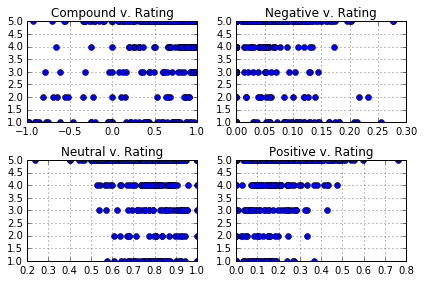

In [27]:
import matplotlib.pyplot as plt
#show visualizations for reviews linked to recalled products
plt.figure(1)

plt.subplot(221)
rating_compound_recall = plt.plot(specified_recall.iloc[:,2], specified_recall.iloc[:,1],'bo')
plt.title('Compound v. Rating')
plt.grid(True)

plt.subplot(222)
rating_neg_recall = plt.plot(specified_recall.iloc[:,3], specified_recall.iloc[:,1],'bo')
plt.title('Negative v. Rating')
plt.grid(True)

plt.subplot(223)
rating_neu_recall = plt.plot(specified_recall.iloc[:,4], specified_recall.iloc[:,1],'bo')
plt.title('Neutral v. Rating')
plt.grid(True)

plt.subplot(224)
rating_pos_recall = plt.plot(specified_recall.iloc[:,5], specified_recall.iloc[:,1],'bo')
plt.title('Positive v. Rating')
plt.grid(True)

plt.tight_layout()
plt.show()

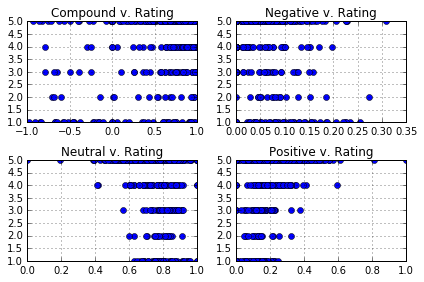

In [28]:
#show visualizations for reviews linked to non-recalled products
plt.figure(1)

plt.subplot(221)
rating_compound_no_recall = plt.plot(specified_no_recall.iloc[:,2], specified_no_recall.iloc[:,1],'bo')
plt.title('Compound v. Rating')
plt.grid(True)

plt.subplot(222)
rating_neg_no_recall = plt.plot(specified_no_recall.iloc[:,3], specified_no_recall.iloc[:,1],'bo')
plt.title('Negative v. Rating')
plt.grid(True)

plt.subplot(223)
rating_neu_no_recall = plt.plot(specified_no_recall.iloc[:,4], specified_no_recall.iloc[:,1],'bo')
plt.title('Neutral v. Rating')
plt.grid(True)

plt.subplot(224)
rating_pos_no_recall = plt.plot(specified_no_recall.iloc[:,5], specified_no_recall.iloc[:,1],'bo')
plt.title('Positive v. Rating')
plt.grid(True)

plt.tight_layout()
plt.show()

Let's quantify these results by finding the correlation between rating and sentiment polarity. It is worth investigating not only the overall correlation but the correlations within the recalled sample as well as the not-recalled sample.

In [29]:
#convert to numpy arrays to facilitate computations
np_df_recall = np.asmatrix(pd.DataFrame.as_matrix(specified_recall.iloc[:,1:]))
np_df_no_recall = np.asmatrix(pd.DataFrame.as_matrix(specified_no_recall.iloc[:,1:]))

In [30]:
from pydoc import help
from scipy.stats.stats import pearsonr
help(pearsonr)

Help on function pearsonr in module scipy.stats.stats:

pearsonr(x, y)
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed, and not necessarily zero-mean.
    Like other correlation coefficients, this one varies between -1 and +1
    with 0 implying no correlation. Correlations of -1 or +1 imply an exact
    linear relationship. Positive correlations imply that as x increases, so
    does y. Negative correlations imply that as x increases, y decreases.
    
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 

In [31]:
correlations = pd.DataFrame(columns = ['recall','no_recall'],\
                           index = ['compound_corr', 'neg_corr', 'neu_corr', 'pos_corr',\
                                   'compound_p', 'neg_p', 'neu_p', 'pos_p'])

correlations.iloc[0,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,1])[0][0]
correlations.iloc[1,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,2])[0][0]
correlations.iloc[2,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,3])[0][0]
correlations.iloc[3,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,4])[0][0]

correlations.iloc[0,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,1])[0][0]
correlations.iloc[1,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,2])[0][0]
correlations.iloc[2,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,3])[0][0]
correlations.iloc[3,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,4])[0][0]

correlations.iloc[4,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,1])[1][0]
correlations.iloc[5,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,2])[1][0]
correlations.iloc[6,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,3])[1][0]
correlations.iloc[7,0] = pearsonr(np_df_recall[:,0], np_df_recall[:,4])[1][0]

correlations.iloc[4,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,1])[1][0]
correlations.iloc[5,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,2])[1][0]
correlations.iloc[6,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,3])[1][0]
correlations.iloc[7,1] = pearsonr(np_df_no_recall[:,0], np_df_no_recall[:,4])[1][0]

In [32]:
correlations

,recall,no_recall
compound_corr,0.408767,0.403089
neg_corr,-0.315259,-0.378355
neu_corr,-0.157743,-0.201295
pos_corr,0.301526,0.359151
compound_p,1.4665e-21,5.87617e-21
neg_p,5.33028e-13,1.83302e-18
neu_p,0.000399216,5.724e-06
pos_p,5.72323e-12,1.14294e-16


In [33]:
correlations_index = pd.MultiIndex(levels = [['recall','no_recall'],['correlation','p-value']],\
                            labels = [[0,0,1,1],[0,1,0,1]])

corr_rec = correlations.iloc[:4,0]
corr_rec.index = range(4)
corr_no_rec = correlations.iloc[:4,1]
corr_no_rec.index = range(4)
p_rec = correlations.iloc[4:,0]
p_rec.index = range(4)
p_no_rec = correlations.iloc[4:,1]
p_no_rec.index = range(4)

In [34]:
final_pearson = pd.concat([corr_rec,p_rec,corr_no_rec,p_no_rec], axis=1)
final_pearson.index = ['compound', 'negative', 'neutral', 'positive']
final_pearson

,recall,recall,no_recall,no_recall
compound,0.408767,1.4665e-21,0.403089,5.87617e-21
negative,-0.315259,5.33028e-13,-0.378355,1.83302e-18
neutral,-0.157743,0.000399216,-0.201295,5.724e-06
positive,0.301526,5.72323e-12,0.359151,1.14294e-16


While our results reveal some moderate correlations at best, the p-values for some indicate that we can draw the conclusion that there is a relationship between the rating and one or more of the polarity scores for both the recall and non-recall samples. Most notably, there is a moderate positive correlation between compound sentiment score and rating with a p-value indicating that this correlation is very significant. We see an only slightly weaker, less significant correlation between compound sentiment score and non-recall reviews.

## Problem of Colinearity in Feature Selection

We see from the above data that there is a positive correlation between rating and text sentiment. This means that selecting both variables as features in a predictive model would be unncessary, as it would ultimately throw out the relatively unimportant variable. Also, the weights applied to each variable would be arbitrary, since they are associated with the same pattern. This also causes numerical issues, because multiple colinear columns can make the matrices almost singular. 

An important topic for further research in this dataset is weeding out features exhibiting colinearity and discerning which features are most descriptive within these collections of closely correlated variables.